In [1]:
!pip install numpy seaborn scikit-learn joblib


In [2]:
pip install scikit-learn==1.3.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0
Note: you may need to restart the kernel to use updated packages.


In [13]:
import joblib
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved models and data
selector = joblib.load('feature_selector.pkl')
forest_important = joblib.load('best_forest_model.pkl')
X_important_test, y_test = joblib.load('test_data.pkl')

              precision    recall  f1-score   support

           0    0.98331   0.99858   0.99089      9145
           1    0.99856   0.98305   0.99074      9146

    accuracy                        0.99082     18291
   macro avg    0.99093   0.99082   0.99081     18291
weighted avg    0.99093   0.99082   0.99081     18291



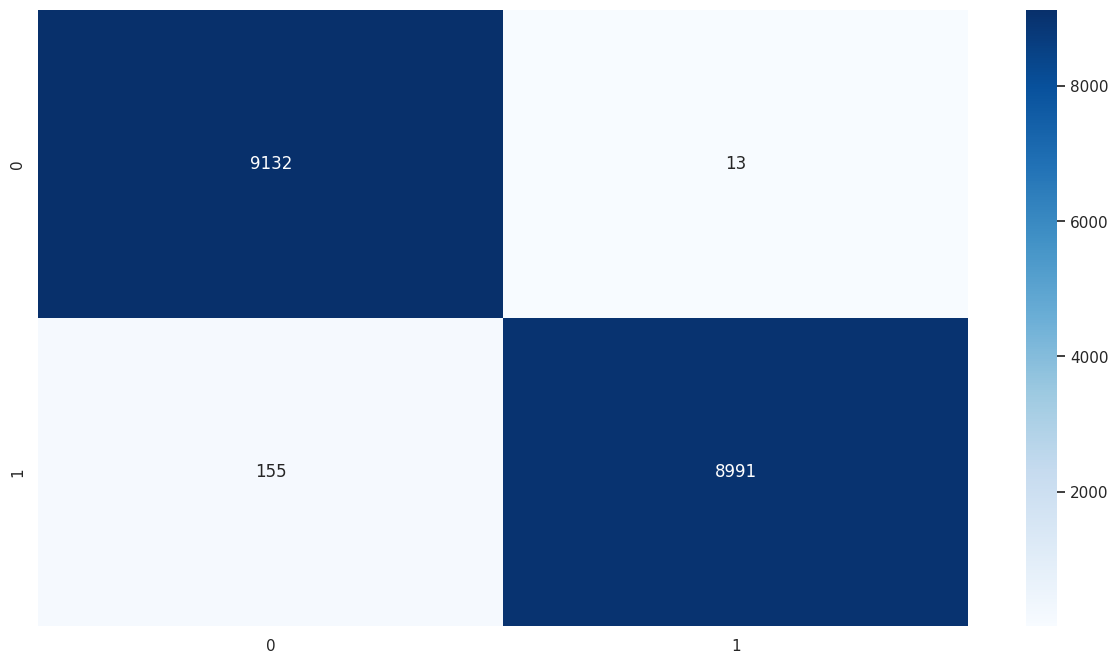

In [14]:
# The ResultPrintout function you provided
def ResultPrintout(model):
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_important_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(y_test, predictions, digits=5)
    
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels))
    print(model_report)  # Predictions and evaluation selected

# Perform prediction on the test set using the loaded model
y_pred = forest_important.predict(X_important_test)

# Use the ResultPrintout function to print the result
ResultPrintout(forest_important)

In [15]:
# Helper function to calculate the number of times each special character appears in the URL
def count_chars(url, char_list):
    return {f"num_{char}_url": url.count(char) for char in char_list}

# Function to check if an email is present in the URL
def check_email_in_url(url):
    return 1 if "@" in url else 0

# Calculate the length of the top-level domain (TLD)
def tld_length(url):
    domain = urlparse(url).netloc
    try:
        return len(domain.split('.')[-1])  # Assuming the last part after the last dot is the TLD
    except IndexError:
        return 0

# New function to check if "&" is greater than "=" in the URL
def amp_greater_than_equal(url):
    num_amp = url.count("&")
    num_equal = url.count("=")
    return 1 if num_amp > num_equal else 0

In [16]:
def domain_features(url):
    first_url = "http://" + url
    parsed_url = urlparse(first_url)
    domain = parsed_url.netloc

    if domain.startswith("www."):
        domain = domain[4:]

    # Calculate the number of dots in the domain
    num_dots_dom = domain.count('.')

    # Calculate the number of hyphens in the domain
    num_hyph_dom = domain.count('-')

    # Calculate the number of underscores in the domain
    num_undeline_dom = domain.count('_')

    # Count the number of vowels in the domain
    num_vowels_dom = sum(1 for char in domain if char in 'aeiouAEIOU')

    # Calculate the length of the domain
    length_dom = len(domain)

    # Check if the domain is in IP format
    dom_in_ip = 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", domain) else 0

    # Check for the presence of "server" or "client" in the domain
    server_client_dom = 1 if 'server' in domain or 'client' in domain else 0

        # Calculate the number of subdomains
    num_subdomains = domain.count('.') - 1

    # Compile all features into a dictionary
    features = {
        'num_dots_dom': num_dots_dom,
        'num_hyph_dom': num_hyph_dom,
        'num_undeline_dom': num_undeline_dom,
        'num_vowels_dom': num_vowels_dom,
        'length_dom': length_dom,
        'dom_in_ip': dom_in_ip,
        'server_client_dom': server_client_dom,
        'num_subdomains': num_subdomains,
    }
    
    return features

In [17]:
def extract_pathname_features(url):
    """
    Extracts features from the pathname of a URL.
    """
    first_url = "http://" + url
    pathname = urlparse(first_url).path

    features = {
        'num_dots_path': pathname.count('.'),
        'num_hyph_path': pathname.count('-'),
        'num_undeline_path': pathname.count('_'),
        'num_slash_path': pathname.count('/'),
        'num_question_path': pathname.count('?'),
        'num_equal_path': pathname.count('='),
        'at_sign_path': pathname.count('@'),
        'num_and_path': pathname.count('&'),
        'num_exclamation_path': pathname.count('!'),
        'num_space_path': pathname.count(' '),
        'tilde_path': pathname.count('~'),
        'num_comma_path': pathname.count(','),
        'num_plus_path': pathname.count('+'),
        'num_asterisk_path': pathname.count('*'),
        'num_hash_path': pathname.count('#'),
        'num_dollar_path': pathname.count('$'),
        'num_percent_path': pathname.count('%'),
        'length_path': len(pathname)
    }
    
    return features

In [18]:
def extract_filename_features(url):
    """
    Extracts features from the filename of a URL.
    """
    first_url = "http://" + url
    # Parse the URL to get the path
    path = urlparse(first_url).path
    # Extract the filename (assuming the filename is the last part of the path)
    filename = path.split('/')[-1] if '/' in path else path
    
    features = {
        'num_dots_file': filename.count('.'),
        'num_hyph_file': filename.count('-'),
        'num_undeline_file': filename.count('_'),
        'num_equal_file': filename.count('='),
        'at_sign_file': filename.count('@'),
        'num_and_file': filename.count('&'),
        'num_exclamation_file': filename.count('!'),
        'num_space_file': filename.count(' '),
        'tilde_file': filename.count('~'),
        'num_comma_file': filename.count(','),
        'num_plus_file': filename.count('+'),
        'num_percent_file': filename.count('%'),
        'length_file': len(filename)
    }
    
    return features

In [19]:
from urllib.parse import urlparse, parse_qs
import pandas as pd

def extract_parameters_features(url):
    """
    Extracts features from the parameters of a URL.
    """
    first_url = "http://" + url
    query_string = urlparse(first_url).query
    params = parse_qs(query_string)
    
    # Counting the occurrences of various symbols in the entire query string
    features = {
        'num_dots_param': query_string.count('.'),
        'num_hyph_param': query_string.count('-'),
        'num_undeline_param': query_string.count('_'),
        'num_slash_param': query_string.count('/'),
        'num_questionmark_param': query_string.count('?'),
        'num_equal_param': query_string.count('='),
        'at_sign_param': query_string.count('@'),
        'num_and_param': query_string.count('&'),
        'num_exclamation_param': query_string.count('!'),
        'num_space_param': query_string.count(' '),
        'tilde_param': query_string.count('~'),
        'num_comma_param': query_string.count(','),
        'num_plus_param': query_string.count('+'),
        'num_asterisk_param': query_string.count('*'),
        'num_dollar_param': query_string.count('$'),
        'num_percent_param': query_string.count('%'),
        'length_param': len(query_string),
        'tld_in_param': int(any(part.endswith(('.com', '.org', '.net', '.edu', '.gov')) for part in query_string.split('&'))),
        'num_param': len(params)
    }
    
    return features

In [20]:
def extract_features(url):
    special_chars = ['.', '-', '_', '/', '?', '=', '@', '&', '!', ' ', '~', ',', '+', '*', '#', '$', '%']
    features = count_chars(url, special_chars)
    # Ensure check_email_in_url returns a dictionary to be compatible with update
    features['email_in_url'] = check_email_in_url(url)  # Adjust this line
    # Assuming tld_length, amp_greater_than_equal return integers, add them directly
    features['num_tld_url'] = tld_length(url)
    features['amp_greater_than_equal'] = amp_greater_than_equal(url)
    features['length_url'] = len(url)
    # Add additional features
    features.update(extract_filename_features(url))
    features.update(domain_features(url))
    features.update(extract_pathname_features(url))
    features.update(extract_parameters_features(url))
    return features


In [21]:
import tkinter as tk
from tkinter import messagebox

def predict_url():
    url = url_entry.get()  # Get URL from entry
    url_features = extract_features(url)  # Extract all features from the URL
    
    features_df = pd.DataFrame([url_features])  # Create a DataFrame from the features
    
    important_features =  selector.transform(features_df.values)  # Use .values to match expected format
    prediction = forest_important.predict(important_features)  # Predict using the model

    # Update the display based on the prediction
    if prediction[0] == 1:  # Assuming 1 means phishing
        result_label.config(bg="red", text="Website is 100% unsafe to use...")
        #continue_button.config(text="Still want to Continue")
    else:  # Assuming 0 means legitimate
        result_label.config(bg="green", text="Website is 94% safe to use...")
        #continue_button.config(text="Continue")

In [23]:
# Set up the main application window
root = tk.Tk()
root.title("Phishing URL Detection")

# Create and place the URL entry
url_label = tk.Label(root, text="Enter URL:")
url_label.pack(pady=5)
url_entry = tk.Entry(root, width=50)
url_entry.pack(pady=5)

# Create and place the 'Check' button
check_button = tk.Button(root, text="Check here", command=predict_url)
check_button.pack(pady=10)

# Create labels for the result and continue button
result_label = tk.Label(root, text="", bg="grey", fg="white", width=50, height=2)
result_label.pack(pady=10)

#continue_button = tk.Button(root, text="", width=20)
#continue_button.pack(pady=5)

# Run the application
root.mainloop()

TclError: no display name and no $DISPLAY environment variable